#Photomath - Iva Smoljko

First of all, let's import all the libraries we will use.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2
import os
from sklearn import preprocessing
from pathlib import Path
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Now, we will install kaggle so we can directly get dataset.

In [3]:
! pip install kaggle

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d clarencezhao/handwritten-math-symbol-dataset

 86% 50.0M/57.8M [00:00<00:00, 102MB/s] 
100% 57.8M/57.8M [00:00<00:00, 118MB/s]


In [ ]:
! unzip handwritten-math-symbol-dataset.zip

After loading and unzipping the dataset, we can see that in the "train" file (located in "content" file) there are files which contain images of handwritten digits and basic mathematical operators (+,-,* and /). There are files which have handwritten decimal point, sign equal as well, but due to the fact that it is not part of our task, I will be ignoring it. However, this dataset does not contain bracket "(" and ")" data, so my Photomath won't be able to recognize it. 

Let's create a list with labels (names of digits and symbols we will use).

In [9]:
labels = ['zero','one','two','three','four','five','six','seven','eight','nine',
          'plus','minus','times','div']

We need to load images for training (from "train" file) and testing (from file "eval").

In [10]:
train_dataset_path = "../content/train"
train_image = []
train_label = []

for labels_dir in os.listdir(train_dataset_path): 
    if labels_dir.split()[0] in labels: #since our labels are one-word, 
    #we split the name of file and only observe if the first word is in
    #array
        for image in os.listdir(train_dataset_path + "/" + labels_dir):
            train_label.append(labels_dir.split()[0])
            train_image.append(train_dataset_path + "/" + labels_dir + "/" + image)

In [11]:
test_dataset_path = "../content/eval"
test_image = []
test_label = []

for labels_dir in os.listdir(test_dataset_path):
    if labels_dir.split()[0] in labels:
        for image in os.listdir(test_dataset_path + "/" + labels_dir):
            test_label.append(labels_dir.split()[0])
            test_image.append(test_dataset_path + "/" + labels_dir + "/" + image)

Let's check how many train and test images we have (and if we did this correctly; number of images should be equal to length of array with labels).

In [12]:
print("Total of train_image: ", len(train_image), ", length of labels list : " ,len(train_label))
print("Total of test_image : " , len(test_image) , ", length of labels list : " ,len(test_label))

Total of train_image:  6490 , length of labels list :  6490
Total of test_image :  854 , length of labels list :  854


In [13]:
#ratio
len(train_image)/(len(train_image) + len(test_image))

0.8837145969498911

As we can see, the numbers of images and labels correspond to each other, and the ratio of training and testing images is nearly 90:10, which we still consider as a "good radio". 

Let's plot random images from train and test dataset.

In [14]:
import random

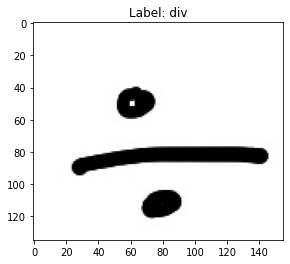

In [15]:
random.seed()
rd = random.randint(1, len(train_image))
image = cv2.imread(train_image[rd])
plt.imshow(image)
plt.title("Label: " + train_label[rd])
plt.show()

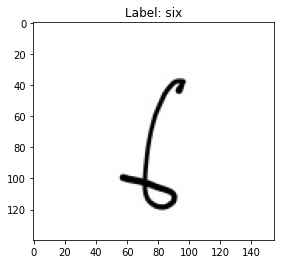

In [16]:
random.seed()
rd1 = random.randint(1, len(test_image))
image = cv2.imread(train_image[rd1])
plt.imshow(image)
plt.title("Label: " + train_label[rd1])
plt.show()

Now, let's check height and width of our images.

In [17]:
train_shapes = []
train_width = []
train_height = []
for path in train_image:
  img = np.array(cv2.imread(path))
  size = img.shape
  if size not in train_shapes:
    train_shapes.append(size) 
    train_width.append(size[0])
    train_height.append(size[1])

if len(train_shapes):
  print("min train width: ", min(train_width))
  print("min train height: ", min(train_height))

min train width:  135
min train height:  150


In [18]:
test_shapes = []
test_width = []
test_height = []
for path in test_image:
  img = np.array(cv2.imread(path))
  size = img.shape
  if size not in test_shapes:
    test_shapes.append(size)
    test_width.append(size[0])
    test_height.append(size[1])

if len(train_shapes):
  print("min test width: ", min(test_width))
  print("min test height: ", min(test_height))

min test width:  135
min test height:  150


Cleary, they differ in sizes. So, to make things easier for later, we will resize them (not a lot) and make them square. Also, our data is in .jpg format, we need to convert it to numpy array.

In [19]:
X_train = []
X_test = []

for path in train_image:    
    img = cv2.imread(path)
    img = cv2.resize(img, (135, 135))
    img = np.array(img)
    X_train.append(img)

for path in test_image:    
    img = cv2.imread(path)
    img = cv2.resize(img, (135, 135))
    img = np.array(img)     
    X_test.append(img)

# X_train and X_test are basic arrays, we will convert them to numpy array 
X_train = np.array(X_train)
X_test = np.array(X_test)

Since normalization reduces the complexity of the problem our network is trying to solve, we will normalize data. This can potentially increase the accuracy of our model and speed up the training, because we bring the data on the same scale and reduce variance along with none of the weights in the network are wasted on doing a normalization for us, meaning that they can be used more efficiently to solve the actual task at hand.

In [20]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [21]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (6490, 135, 135, 3)
X_test shape:  (854, 135, 135, 3)


We need to adjust labels.

In [22]:
label_encoder = preprocessing.LabelEncoder()
y_train_temp = label_encoder.fit_transform(train_label)
y_test_temp = label_encoder.fit_transform(test_label)

In [23]:
for i in range(len(labels)):
  print(label_encoder.classes_[i], "is encoded as: ", i)

div is encoded as:  0
eight is encoded as:  1
five is encoded as:  2
four is encoded as:  3
minus is encoded as:  4
nine is encoded as:  5
one is encoded as:  6
plus is encoded as:  7
seven is encoded as:  8
six is encoded as:  9
three is encoded as:  10
times is encoded as:  11
two is encoded as:  12
zero is encoded as:  13


In [24]:
print("y_train_temp shape: ", y_train_temp.shape)
print("y_test_temp shape: ", y_test_temp.shape)

y_train_temp shape:  (6490,)
y_test_temp shape:  (854,)


Next, we need to create a matrix labels list.

In [25]:
y_train = tf.keras.utils.to_categorical(y_train_temp, len(labels))
y_test = tf.keras.utils.to_categorical(y_test_temp, len(labels))


print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (6490, 14)
y_test shape:  (854, 14)


Now, everything is ready for creating our model. We will use sequential model, which means we can do it "layer-by-layer".

In [26]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(135, 135, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))

# maxpooling will take highest value from a filter of 2*2 shape
model.add(MaxPooling2D(pool_size=(2, 2)))

# it will prevent overfitting by making it hard for the model to idenify the images
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

# last layer predicts 14 labels
model.add(Dense(len(labels), activation="softmax"))

In [27]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 135, 135, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 133, 133, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 66, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 66, 66, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 66, 66, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

Let's train model.

In [28]:
history = model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=200,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/200
104/104 [==============================] - 31s 179ms/step - loss: 1.9860 - accuracy: 0.3631 - val_loss: 12.7332 - val_accuracy: 0.1626
Epoch 2/200
104/104 [==============================] - 16s 152ms/step - loss: 0.8399 - accuracy: 0.7411 - val_loss: 15.6130 - val_accuracy: 0.1841
Epoch 3/200
104/104 [==============================] - 16s 151ms/step - loss: 0.4358 - accuracy: 0.8648 - val_loss: 17.8723 - val_accuracy: 0.1918
Epoch 4/200
104/104 [==============================] - 16s 151ms/step - loss: 0.2997 - accuracy: 0.9049 - val_loss: 18.4546 - val_accuracy: 0.1988
Epoch 5/200
104/104 [==============================] - 16s 151ms/step - loss: 0.1859 - accuracy: 0.9393 - val_loss: 21.6545 - val_accuracy: 0.2180
Epoch 6/200
104/104 [==============================] - 16s 151ms/step - loss: 0.1325 - accuracy: 0.9551 - val_loss: 23.6061 - val_accuracy: 0.2288
Epoch 7/200
104/104 [==============================] - 16s 151ms/step - loss: 0.1093 - accuracy: 0.9646 - val_loss: 24

We will visualize the outcome and model loss.

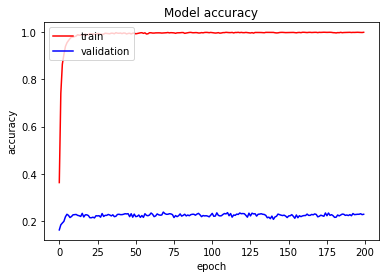

In [29]:
# displaying the model accuracy
plt.plot(history.history['accuracy'], label='train', color="red")
plt.plot(history.history['val_accuracy'], label='validation', color="blue")
plt.title('Model accuracy')
plt.legend(loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

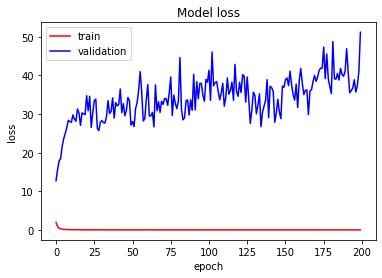

In [30]:
# displaying the model loss
plt.plot(history.history['loss'], label='train', color="red")
plt.plot(history.history['val_loss'], label='validation', color="blue")
plt.title('Model loss')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [31]:
score, acc = model.evaluate(X_train, y_train)
print('Train score:', score)
print('Train accuracy:', acc)

203/203 [==============================] - 7s 33ms/step - loss: 10.2352 - accuracy: 0.8458
Train score: 10.235199928283691
Train accuracy: 0.8457627296447754


In [32]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

27/27 [==============================] - 1s 47ms/step - loss: 11.9627 - accuracy: 0.7963
Test score: 11.962702751159668
Test accuracy: 0.7962529063224792


Now, let's see how model predicts.

In [33]:
pred = model.predict(X_test)
pred

array([[4.1568598e-28, 2.2945465e-05, 4.8797793e-19, ..., 9.9997711e-01,
        1.0013192e-18, 1.6492492e-23],
       [1.5208217e-37, 1.7785304e-21, 1.0528055e-26, ..., 1.0000000e+00,
        5.7572244e-27, 5.7034447e-29],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [6.0061917e-25, 3.6242586e-08, 2.8798316e-20, ..., 6.2181481e-14,
        1.6719757e-16, 1.6882762e-04],
       [4.5935465e-16, 1.6222966e-01, 1.0970792e-12, ..., 6.8881342e-08,
        2.4118638e-08, 8.0545169e-01],
       [5.3438473e-22, 5.9904376e-13, 7.1093451e-09, ..., 4.4920245e-17,
        1.3480002e-12, 1.3944393e-09]], dtype=float32)

Visualized:

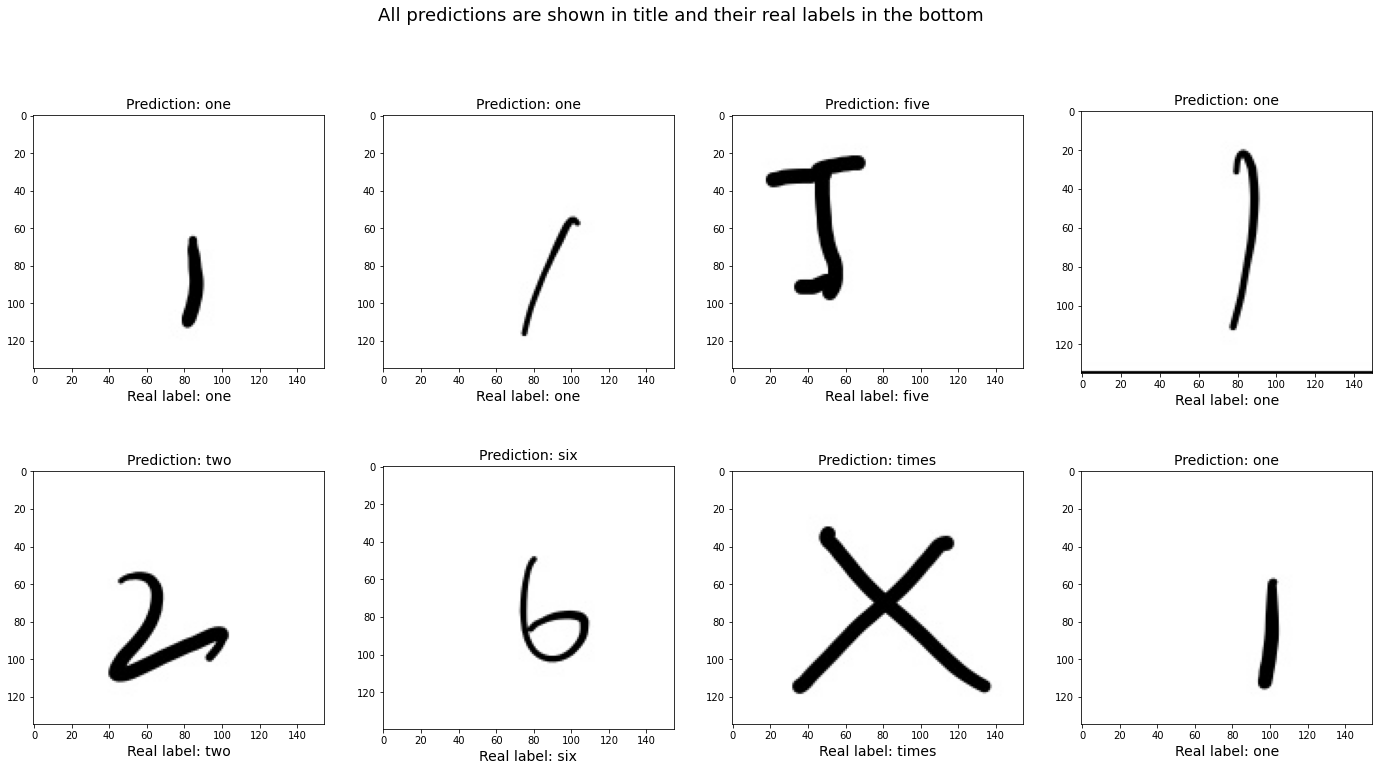

In [34]:
fig, axs= plt.subplots(2,4, figsize=[24,12])

random_pos = []
count = 0

for i in range(8):
  random.seed()
  random_pos.append(random.randint(1, len(test_image)))


for i in range(2):    
    for j in range(4):  
        
        image = cv2.imread(test_image[random_pos[count]])
      
        img = cv2.resize(image, (135, 135))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        img = img.astype('float32')
        img /= 255
        
        pred = model.predict(img)
        result = np.argsort(pred)
        result = result[0][::-1]
        
        final_label = label_encoder.inverse_transform(np.array(result))
        axs[i][j].imshow(image)
        axs[i][j].set_title(str("Prediction: " + final_label[0]), fontsize = 14)  
        axs[i][j].set_xlabel("Real label: "+ test_label[random_pos[count]], fontsize = 14)      
        
        count += 1
        
plt.suptitle("All predictions are shown in title and their real labels in the bottom", fontsize = 18)        
plt.show()

(140, 460, 3)


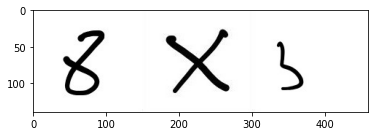

In [104]:
proba = cv2.imread('../content/test_data/test0.jpg')
plt.imshow(proba)
print(proba.shape)

(99, 99, 3)
(135, 135, 3)
(97, 97, 3)
(135, 135, 3)
(77, 77, 3)
(135, 135, 3)


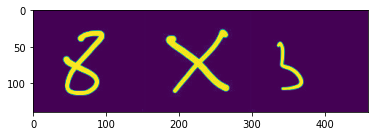

In [105]:
if proba is not None:
  proba_original=proba
  proba=~proba
  proba=cv2.convertScaleAbs(proba)
  proba = cv2.cvtColor(proba, cv2.COLOR_RGB2GRAY)
  

  plt.imshow(proba)
  niz=[]
  _,threshold=cv2.threshold(proba,127,255, cv2.THRESH_BINARY) 
  #thresholding is a technique which is the assignment of pixel values in relation to the threshold value 
  #provided. In thresholding, each pixel value is compared with the threshold value. If the pixel value is 
  #smaller than the threshold, it is set to 0, otherwise, it is set to a maximum value (generally 255).
  
  
  ctrs, _=cv2.findContours(threshold, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  cnt=sorted(ctrs, key=lambda ctr:cv2.boundingRect(ctr)[0])
  
  w=int(28)
  h=int(28)
  train_data=[]
  rects=[]
  for c in cnt:
    x,y,w,h = cv2.boundingRect(c)
    rect=[x,y,w,h]
    rects.append(rect)
  #print("rects",rects)
  bool_rect=[]
  for r in rects:
    l=[]
    for rec in rects:
      flag=0
      if rec !=r:
        if r[0]<(rec[0]+rec[2]+10) and rec[0]<(r[0]+r[2]+10) and r[1]<(rec[1]+rec[3]+10) and rec[1]<(r[1]+r[3]+10):
          flag=1
        l.append(flag)
      if rec==r:
        l.append(0)
    bool_rect.append(l)
  #print("bools",bool_rect)
  dump_rect=[]
  for i in range(0,len(cnt)):
    for j in range(0,len(cnt)):
      if bool_rect[i][j] ==1:
        area1=rects[i][2]*rects[i][3]
        area2=rects[j][2]*rects[j][3]
        if(area1==min(area1,area2)):
          dump_rect.append(rects[i])
  #print("dump", dump_rect)
  final_rects=[i for i in rects if i not in dump_rect]
  #print("final", final_rects)
  for r in final_rects:
    x=r[0]
    y=r[1]
    w=r[2]
    h=r[3]
    proba_crop=proba_original[y:y+h+10, x:x+h+10]
    print(proba_crop.shape)
    #plt.imshow(proba_crop)
    
  
    proba_resize = cv2.resize(proba_crop,(135,135))
    print(proba_resize.shape)
    niz.append(proba_resize)

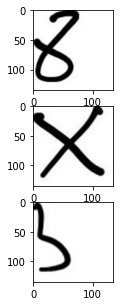

In [106]:
fig, axs= plt.subplots(3, figsize=[5,5])
for i in range(1):
  for j in range(3):
    axs[j].imshow(niz[j])

plt.show()

In [107]:
s= ""
for i in range(len(niz)):
  niz[i]=np.array(niz[i])

  niz[i] = np.expand_dims(niz[i], axis=0)
  niz[i]=niz[i].astype('float32')
  niz[i]/=255
  
  pred=model.predict(niz[i])
  result = np.argsort(pred)
  result = result[0][::-1]

  final_label = label_encoder.inverse_transform(np.array(result))
  print(final_label[0])


  if(final_label[0] == "zero"):
    s+="0"
  if(final_label[0] == "one"):
    s+="1"
  if(final_label[0] == "two"):
    s+="2"
  if(final_label[0] == "three"):
    s+="3"
  if(final_label[0] == "four"):
    s+="4"
  if(final_label[0] == "five"):
    s+="5"
  if(final_label[0] == "six"):
    s+="6"
  if(final_label[0] == "seven"):
    s+="7"
  if(final_label[0] == "eight"):
    s+="8"
  if(final_label[0] == "nine"):
    s+="9"
  if(final_label[0] == "plus"):
    s+="+"
  if(final_label[0] == "minus"):
    s+="-"
  if(final_label[0] == "times"):
    s+="*"
  if(final_label[0] == "div"):
    s+="/"    

print(s)

eight
times
three
8*3


In [108]:
def MakeANum(s):
  br=0
  for j in range(1,len(s)+1):
    br+= int(s[j-1])*pow(10, len(s)-j)
  return br

In [109]:
def Add(a,b):
  return MakeANum(a)+MakeANum(b)

def Sub(a,b):
  return MakeANum(a)-MakeANum(b)

def Mul(a,b):
  return MakeANum(a)*MakeANum(b)

def Div(a,b):
  if(int(b)!=0):
    return MakeANum(a)/MakeANum(b)
  else:
    return "Trying to divide by 0!"
    

In [110]:
for i in range(len(s)):
  if(s[i]=='+'):
    print("The final solution is: ",Add(s[0:i],s[i+1:]))
  elif(s[i]=='-'):
    print("The final solution is: ",Sub(s[0:i],s[i+1:]))
  elif(s[i]=='*'):
    print("The final solution is: ",Mul(s[0:i],s[i+1:]))
  elif(s[i]=='/'):
    print("The final solution is: ",Div(s[0:i],s[i+1:]))

The final solution is:  24


In [ ]:
# #ovo ti je za spajanje slika


# from PIL import Image
# #Read the two images
# image1 = Image.open('images/elephant.jpg')
# image1.show()
# image2 = Image.open('images/ladakh.jpg')
# image2.show()
# #resize, first image
# image1 = image1.resize((426, 240))
# image1_size = image1.size
# image2_size = image2.size
# new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
# new_image.paste(image1,(0,0))
# new_image.paste(image2,(image1_size[0],0))
# new_image.save("images/merged_image.jpg","JPEG")
# new_image.show()

##1. Implement a handwritten character detector

-The implementation should be able to receive an image in a form of numpy array.

-For each detected character it should return its coordinates and a cropped image (cropped to its bounding box).

-Use OpenCV.

##2. Implement a handwritten character classifier

-The implementation should be able to receive a cropped image of the character and return the classification result (the correct label).

-Use convolutional neural networks. Use tensorflow or keras with tensorflow backend.

-Report the metrics you find useful and comment on them.

##3. Implement a solver

-Implementation should be able to receive the expression in a form of a string, parse it and calculate the result.

-Parsing and solving should be done without calls to eval or external libraries.

##Combine it all together

-Implement a method which will, for a given image of a math expression return its result.

-Measure and discuss the real-world problems and compare them to metrics and comments in 2.

-Propose improvements.